# <font color='darkblue'> Recommendations with IBM Watson. Part II</font>

## <font color='darkblue'> Rank and Content Based Recommendations</font>


In this notebook, we build a rank based recommender to address the cold start problem. Next we investigate several approaches to content based recommender engines. The dataset is real data from the IBM Watson Studio platform. 

## <font color='darkblue'>Environment SetUp</font>

In [1]:
# General libraries and packages

import pandas as pd
import numpy as np
import re

from ast import literal_eval

# Packages and libraries for content based recs
import re

# NLP packages
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.cluster import KMeansClusterer
import nltk


# Data processing packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

# Import linear kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

In [3]:
# Use 2 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 90)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", 20)

## <font color='darkblue'>Upload Preprocessed Data</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>There are 2 files to upload.</li>
        <li>One is centered on the user information, the other on the article information.</li>
    </ul>

</div>

In [4]:
# Read in the user-item interaction files
articles_per_user = pd.read_csv('data/articles_per_user.csv', 
                                index_col=[0], 
                                converters={'viewed_articles': literal_eval}) 

# Read the articles information files
users_per_article = pd.read_csv('data/users_per_article.csv', 
                                index_col=[0],
                               converters={'users_accessed': literal_eval}) 

In [5]:
# Check the user_item dataframes
articles_per_user.head(2)

,user_id,viewed_articles,articles_count,unique_articles_count
0,1,"[1430, 1430, 732, 1429, 43, 109, 1232, 310, 1293, 1406, 1406, 329, 585, 310, 1305, 105...",47,36
1,2,"[1314, 1305, 1024, 1176, 1422, 1427]",6,6


In [6]:
articles_per_user.dtypes

user_id                   int64
viewed_articles          object
articles_count            int64
unique_articles_count     int64
dtype: object

In [7]:
# Check the articles information dataframe
users_per_article.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1,0,Communicating data science: A guide to presenting your work,[]


## <a class="anchor" id="Rank">Rank-Based Recommendations</a>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
<li>The dataset does not contain ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can be based on how often an article was interacted with.</li>
    </ul>

</div>

### <font color='darkblue'>Get the top n most popular articles</font>

In [8]:
# Function to retrieve the ids and title of the most viewed n articles
def get_top_articles(n):
    
    '''
    Finds the n most popular articles.
    
    INPUT:
        n (int) - specifies how many items should be returned
    OUTPUT:
        article_ids (list) - the ids of the n most popular articles
        titles (list) - the titles of the n most popular articles
    '''
    
    df_top_n = users_per_article.nlargest(n, 'views')
    titles = list(df_top_n.doc_name)
    article_ids = list(df_top_n.article_id)
    return article_ids, titles

In [9]:
# The ids of the 10 most popular articles
most_popular_ids = get_top_articles(10)[0]
most_popular_ids

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]

In [10]:
# The titles of the 10 most popular articles
most_popular_titles = get_top_articles(10)[1]
most_popular_titles

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

## <a class="anchor" id="Content-Recs">Content Based Recommendations</a>

## <font color='darkblue'>Baseline Model</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
<li>In this section we work with users_per_article dataframe that contains content information.</li>
<li>The text is preprocessed using a tokenizer function, then vectorized with TfidfVectorizer from sklearn.</li>
<li>The cosine similarity scores are computed with linear_kernel in sklearn.</li>
</ul>

</div>

In [11]:
# Make a copy of the dataframe
content = users_per_article.copy()

In [12]:
# Dataframe that retains article_id and doc_name 
df_titles = content[['article_id', 'doc_name']]

# check the output
df_titles.head(2)

,article_id,doc_name
0,0,detect malfunctioning iot sensors with streaming analytics
1,1,Communicating data science: A guide to presenting your work


### <font color='darkblue'>Preprocess text and create TF-IDF matrix</font>

In [13]:
def tokenize(text):
    
    """
    Contains the pre-processing steps for a document:
        - tokenize
        - lemmatize
        - lowercasing
        - removes stopwords in English language
        
    INPUT (string) - raw message
    OUTPUT (list)  - clean tokens
    """
    
    # remove punctuation and unusual characters 
    #text = re.sub(r"[^a-zA-Z0-9]", " ", text).strip()
    # remove punctuation, unusual characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text).strip()
    
    
    # split into words
    words = word_tokenize(text)
    
    # lemmatize - reduce words to their root form
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    # case normalize and remove leading & trailing empty spaces
    words = [w.lower().strip() for w in words]
    
    # adjust the list of stopwords
    nltk_stopwords = stopwords.words('english')
    #nltk_stopwords.append('none')
    
    # remove stopwords, keep not, can
    clean_words = [w for w in words if w not in nltk_stopwords or w in ['not', 'can']]
    
    return clean_words

Comments: 

```
# Use these lines if more than one stopword is added
nltk_stopwords = stopwords.words('english')
new_stopwords = ['word1','word2']
stopwords.extend(new_stopwords)

# Use these lines if one stopword is added
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('new_word')
```

In [14]:
# Create an instance of the TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Construct the TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(df_titles['doc_name'])

In [15]:
# Output the shape of the TF-IDF matrix
tfidf_matrix.shape

(1328, 1861)

### <font color='darkblue'>Compute the cosine similarity scores</font>

In [16]:
# Compute the cosine similarity matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# Check the output
cosine_sim.shape

(1328, 1328)

### <font color='darkblue'>Build the recommender function</font>

In [17]:
def get_article_info(article_id, df_titles):
    '''
    Returns the title that corresponds to an article id.
    
    INPUT:
    article_id (int) - unique article identifier
    df_titles (pd.DataFrame) - contains article_id, title
    
    OUTPUT:
    article_title (str) - the article name associated with the provided article id
    '''
    
    article_title = df_titles[df_titles['article_id']==article_id]['doc_name'].unique()[0]
    return article_id, article_title

In [18]:
# Print a sample output
print(f'The title of the article with id = 542 is: {get_article_info(542, df_titles)[1]}.')

The title of the article with id = 542 is: getting started with python.


In [19]:
# Function that takes in the article id as input and gives n recommendations
def content_recommender_tfidf(article_id, n, cosine_sim, df_titles):
    '''
    INPUT:
    article_id (int) - unique article identifier
    n (int) - how many recommendations should be returned
    cosine_sim (np.ndarray) - matrix of cosine similarities
    df (pd.DdataFrame) - contains title and article id
    
    OUTPUT:
    recommended_articles (list) - recommended articles (ids and titles), 
                                  sorted by cosine similarity
    '''
    # Get the information for the given article id
    given_article = get_article_info(article_id, df_titles)
    
    # Obtain the matrix index that matches the article id
    matrix_index = df_titles[df_titles['article_id']==article_id].index.values[0]
    
    # Sort the scores based on the cosine similarity scores with given article index, ignore the first entry
    sim_scores = pd.Series(cosine_sim[matrix_index]).sort_values(ascending=False).iloc[1:]
    
    # Get the indices corresponding to the scores of the n most similar articles
    sim_scores_n = list(sim_scores[:n].index.values)
    
    # Return the top n most similar article_ids as a pandas dataframe
    recommended_articles = df_titles.iloc[sim_scores_n]
    
    return given_article, recommended_articles

### <font color='darkblue'>Make content recommendations with the baseline model</font>

In [20]:
def make_content_recs_tfidf(user_id, 
                      cosine_sim, 
                      m, 
                      df=articles_per_user, 
                      df_content=users_per_article):
    '''
    INPUT:
        user_id (int) - unique numeric user identifier
        m (int) - the number of recommendations we want for the user
        df (pd.DataFrame) - contains users and articles interactions
        df_content (pd.DataFrame) - contains titles and article_ids
    
    OUTPUT:
        recs_ids (list) - list of recommendations for the user by article id
        rec_names (list) - list of recommendations for the user by article title
    
    Description:
        Loops through the articles based on closeness to the articles seen by the user.
        For each article seen by the user - finds n most similar articles based on 
        content recommendations. Does this until m recommendations are found.
    
    Notes:
        The articles that have the most total article interactions are chosen first.
   
    '''
    # List of recommended articles by id, and by title
    recommendations = []
    
    # Ids of articles seen by user  
    articles_ids_seen = articles_per_user.loc[user_id].viewed_articles
    
    for art_id in articles_ids_seen:
        
        # choose n such that we get similar articles to all articles viewed
        if len(articles_ids_seen) >= 5:
            n = 2
        elif len(articles_ids_seen) == 4:
            n = 3
        else:
            n = 10
        
         # get the n most similar articles ids and titles
        similar_articles_ids = content_recommender_tfidf(
            art_id, n, cosine_sim, df_titles)[1]['article_id'].tolist()
        similar_articles = content_recommender_tfidf(
            art_id, n, cosine_sim, df_titles)[1]['doc_name'].tolist()

        # remove the ids of the articles in articles_ids_seen and available
        articles_ids_to_recommend = np.setdiff1d(
            similar_articles_ids, articles_ids_seen)
        
        # remove the articles already added to the recs list
        articles_ids_to_add = np.setdiff1d(
            articles_ids_to_recommend, recommendations)
        
        # add the sorted article ids
        recommendations.extend(articles_ids_to_add)
        
        # break when we have enough articles to recommend
        if len(recommendations) >= m:
            break
    
    # retain the first m recommendations
    recs = recommendations[:m]
    
    # get the articles titles
    complete_recs = [get_article_info(article_id, df_titles) for article_id in recs]
    
    return complete_recs


## <font color='darkblue'>Sentence Transformers</font>

In [21]:
# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer, util
import torch

# Create the model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create embeddings for the collection of titles
corpus_embeddings = model.encode(df_titles.doc_name.values, 
                                 convert_to_tensor=True)

In [22]:
# Function that takes in the article id as input and gives n recommendations
def content_recommender_transformer(article_id, k, df_titles):
    
    '''
    Function that takes in an article_id and an integer n, to return 
    n articles ids and titles, recommended based on the cosine similarity scores.
    
    INPUT:
    article_id (int) - unique article identifier
    k (int) - how many recommendations should be returned
    cosine_sim (np.ndarray) - matrix of cosine similarities
    df_titles (pd.DdataFrame) - contains title and article id
    
    OUTPUT:
    recommended_articles (list) - recommended articles (ids and titles), 
                                  sorted by cosine similarity
    '''
    # Get the information for the given article id
    select_title = get_article_info(article_id, df_titles)[1]
    
    # Create an embedding for select article title
    select_article_embedding = model.encode(select_title, convert_to_tensor=True)
    
    # Compute cosine similarity scores between the select article and the corpus
    cos_scores = util.pytorch_cos_sim(select_article_embedding, corpus_embeddings)[0]
    
    # Select the highest n scores
    top_results = torch.topk(cos_scores, k)
    
    # Get a list of recommended article ids
    top_ids = top_results[1].tolist()[1:]
    
    # Return the top k most similar article_ids and titles as a pandas dataframe
    recommended_articles = df_titles.iloc[top_ids]
    
    return select_title, recommended_articles

### <font color='darkblue'>Make content recommendations with transformers</font>

In [23]:
def make_content_recs_transformers(user_id, m, 
                      df=articles_per_user, 
                      df_content=users_per_article):
    '''
    INPUT:
        user_id (int) - unique numeric user identifier
        m (int) - the number of recommendations we want for the user
        df (pd.DataFrame) - contains users and articles interactions
        df_content (pd.DataFrame) - contains titles and article_ids
    
    OUTPUT:
        recs_ids (list) - list of recommendations for the user by article id
        rec_names (list) - list of recommendations for the user by article title
    
    Description:
        Loops through the articles based on closeness to the articles seen by the user.
        For each article seen by the user - finds n most similar articles based on 
        content recommendations. Does this until m recommendations are found.
    
    Notes:
        The articles that have the most total article interactions are chosen first.
   
    '''
    # List of recommended articles by id, and by title
    recommendations = []
    
    # Ids of articles seen by user  
    articles_ids_seen = articles_per_user.loc[user_id].viewed_articles
    
    for art_id in articles_ids_seen:
        
        # choose n such that we get similar articles to all articles viewed
        if len(articles_ids_seen) >= 5:
            n = 2
        elif len(articles_ids_seen) == 4:
            n = 3
        else:
            n = 10
        
        # get the n most similar articles ids and titles
        similar_articles_ids = content_recommender_transformer(
            art_id, n, df_titles)[1]['article_id'].tolist()
        similar_articles = content_recommender_transformer(
            art_id, n, df_titles)[1]['doc_name'].tolist()

        # remove the ids of the articles in articles_ids_seen and available
        articles_ids_to_recommend = np.setdiff1d(
            similar_articles_ids, articles_ids_seen)
        
        # remove the articles already added to the recs list
        articles_ids_to_add = np.setdiff1d(
            articles_ids_to_recommend, recommendations)
        
        # add the sorted article ids
        recommendations.extend(articles_ids_to_add)
        
        # break when we have enough articles to recommend
        if len(recommendations) >= m:
            break
    
    # retain the first m recommendations
    recs = recommendations[:m]
    
    # get the articles titles
    complete_recs = [get_article_info(article_id, df_titles) for article_id in recs]
    
    return complete_recs


### <font color='darkblue'>Examples: finding similar articles</font>

In [24]:
# Choose the id for the test article
article_id = 20

# Create the list of recommendations using the baseline model
recommendations_tfidf_list_20 = content_recommender_tfidf(article_id, 10, cosine_sim, df_titles)

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_20[0][1]}')

# Print the recommended articles information
print(f'\nThe baseline model recommended articles are:')
recommendations_tfidf_list_20[1]

The article with id = 20 for which we give recommendations is:
working interactively with rstudio and notebooks in dsx

The baseline model recommended articles are:


,article_id,doc_name
373,373,working with notebooks in dsx
763,763,load data into rstudio for analysis in dsx
240,240,spark 1.4 for rstudio
182,182,Overview of RStudio IDE in DSX
355,355,run shiny applications in rstudio in dsx
626,626,analyze db2 warehouse on cloud data in rstudio in dsx
665,665,get social with your notebooks in dsx
958,958,using dsx notebooks to analyze github data
474,474,publish notebooks to github in dsx
930,930,how to use version control (github) in rstudio within dsx?


In [25]:
# Print the recommended articles using transformers
print(f'\nThe transformer model recommended articles are:')
recommendations_transf_list_20 = content_recommender_transformer(20, 11, df_titles)
recommendations_transf_list_20[1]


The transformer model recommended articles are:


,article_id,doc_name
373,373,working with notebooks in dsx
182,182,Overview of RStudio IDE in DSX
763,763,load data into rstudio for analysis in dsx
665,665,get social with your notebooks in dsx
821,821,using rstudio in ibm data science experience
474,474,publish notebooks to github in dsx
806,806,Collaborate on projects in DSX
355,355,run shiny applications in rstudio in dsx
395,395,run dsx notebooks on amazon emr
277,277,work with data connections in dsx


In [26]:
list_transf_20 = recommendations_transf_list_20[1].article_id.values
list_tfidf_20 = recommendations_tfidf_list_20[1].article_id.values

transf_not_tfidf = list(set(list_transf_20) - set(list_tfidf_20))
tfidf_not_transf = list(set(list_tfidf_20) - set(list_transf_20))

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_20[0][1]}')

# The articles recommended by transformer model but not by baseline 
print(f'\nArticles recommended by transformer but not by baseline model:')

for art_id in transf_not_tfidf:
    print(get_article_info(art_id, df_titles))

# The articles recommended by the baseline model, but not by the transformer model
print(f'\nArticles recommended by baseline but not by transformer model:')

for art_id in tfidf_not_transf:
    print(get_article_info(art_id, df_titles))

The article with id = 20 for which we give recommendations is:
working interactively with rstudio and notebooks in dsx

Articles recommended by transformer but not by baseline model:
(277, 'work with data connections in dsx')
(395, 'run dsx notebooks on amazon emr')
(821, 'using rstudio in ibm data science experience')
(806, 'Collaborate on projects in DSX')

Articles recommended by baseline but not by transformer model:
(240, 'spark 1.4 for rstudio')
(930, 'how to use version control (github) in rstudio within dsx?')
(958, 'using dsx notebooks to analyze github data')
(626, 'analyze db2 warehouse on cloud data in rstudio in dsx')


In [27]:
# Choose the id for the test article
article_id = 500

# Create the list of recommendations using baseline model
recommendations_tfidf_list_500 = content_recommender_tfidf(article_id, 10, cosine_sim, df_titles)

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_500[0][1]}')

# Print the recommended articles information
print(f'\nThe baseline model recommended articles are:')
recommendations_tfidf_list_500[1]

The article with id = 500 for which we give recommendations is:
the difference between ai, machine learning, and deep learning?

The baseline model recommended articles are:


,article_id,doc_name
313,313,what is machine learning?
260,260,the machine learning database
762,762,From Machine Learning to Learning Machine (Dinesh Nirmal)
237,237,deep learning with data science experience
1035,1035,machine learning for the enterprise.
800,800,machine learning for the enterprise
336,336,challenges in deep learning
337,337,generalization in deep learning
784,784,"10 data science, machine learning and ai podcasts you must listen to"
1004,1004,how to get a job in deep learning


In [28]:
# Print the recommended articles information
print(f'\nThe transformer model recommended articles are:')
recommendations_transf_list_500 = content_recommender_transformer(500, 11, df_titles)
recommendations_transf_list_500[1]


The transformer model recommended articles are:


,article_id,doc_name
336,336,challenges in deep learning
278,278,deep learning trends and an example
337,337,generalization in deep learning
313,313,what is machine learning?
762,762,From Machine Learning to Learning Machine (Dinesh Nirmal)
1313,1429,use deep learning for image classification
237,237,deep learning with data science experience
833,833,machine learning and the science of choosing
195,195,"artificial intelligence, ethically speaking – inside machine learning – medium"
532,532,the two phases of gradient descent in deep learning


In [29]:
list_transf_500 = recommendations_transf_list_500[1].article_id.values
list_tfidf_500 = recommendations_tfidf_list_500[1].article_id.values

transf_not_tfidf = list(set(list_transf_500) - set(list_tfidf_500))
tfidf_not_transf = list(set(list_tfidf_500) - set(list_transf_500))

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_500[0][1]}')

# The articles recommended by transformer model but not by baseline 
print(f'\nArticles recommended by transformer but not by baseline model:')

for art_id in transf_not_tfidf:
    print(get_article_info(art_id, df_titles))

    # The articles recommended by the baseline model, but not by the transformer model
print(f'\nArticles recommended by baseline but not by transformer model:')

for art_id in tfidf_not_transf:
    print(get_article_info(art_id, df_titles))

The article with id = 500 for which we give recommendations is:
the difference between ai, machine learning, and deep learning?

Articles recommended by transformer but not by baseline model:
(833, 'machine learning and the science of choosing')
(195, 'artificial intelligence, ethically speaking – inside machine learning – medium')
(532, 'the two phases of gradient descent in deep learning')
(1429, 'use deep learning for image classification')
(278, 'deep learning trends and an example')

Articles recommended by baseline but not by transformer model:
(800, 'machine learning for the enterprise')
(260, 'the machine learning database')
(1035, 'machine learning for the enterprise.')
(1004, 'how to get a job in deep learning')
(784, '10 data science, machine learning and ai podcasts you must listen to')


### <font color='darkblue'>Examples: Make content recommendations</font>

In [30]:
# Take a look at the unique articles seen by user_id=40
articles_ids_seen_40 = articles_per_user.loc[40].viewed_articles
articles_seen_40 = [get_article_info(article_id, 
                                     df_titles) for article_id in articles_ids_seen_40]
print(f'The articles accessed by user_id=40 are:')
set(articles_seen_40)

The articles accessed by user_id=40 are:


{(151, 'jupyter notebook tutorial'),
 (162, 'an introduction to stock market data analysis with r (part 1)'),
 (486, 'use spark r to load and analyze data'),
 (542, 'getting started with python'),
 (645, 'how to perform a logistic regression in r'),
 (692, '15 page tutorial for r'),
 (1198, 'country statistics: commercial bank prime lending rate'),
 (1304, 'gosales transactions for logistic regression model'),
 (1368, 'putting a human face on machine learning'),
 (1430,
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'),
 (1436, 'welcome to pixiedust')}

In [31]:
# Take a look at the list of recommended articles using the baseline model
print(f'The articles recommended by baseline model to user_id=40 are:')
recs_tfidf_40 = make_content_recs_tfidf(40, cosine_sim, 10, 
                                        articles_per_user, users_per_article)
recs_tfidf_40

The articles recommended by baseline model to user_id=40 are:


[(82, 'build a logistic regression model with wml & dsx'),
 (1305, 'gosales transactions for naive bayes model'),
 (110, 'pixiedust: magic for your python notebook'),
 (729, 'pixiedust 1.0 is here! – ibm watson data lab'),
 (329, 'introduction to market basket analysis in\xa0python'),
 (886, 'Perform market basket analysis using dashDB and R'),
 (108,
  '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object'),
 (528, '10 tips on using jupyter notebook'),
 (855, 'enjoy python 3.5 in jupyter notebooks'),
 (671, 'Libraries and Tutorials')]

In [32]:
# Separate tuples of ids and titles for the recommended articles
recs_tfidf_40_ids, recs_tfidf_40_titles = zip(*recs_tfidf_40)

In [33]:
# Take a look at the list of recommended articles using the transformer model
print(f'The articles recommended by the transformer model to user_id=40 are:')
recs_transf_40 = make_content_recs_transformers(40, 12, 
                                        articles_per_user, users_per_article)
recs_transf_40

The articles recommended by the transformer model to user_id=40 are:


[(617, 'pixiedust gets its first community-driven feature in 1.0.4'),
 (886, 'Perform market basket analysis using dashDB and R'),
 (1161, 'analyze data, build a dashboard with spark and pixiedust'),
 (528, '10 tips on using jupyter notebook'),
 (351, 'do i need to learn r?'),
 (1425, 'use spark for r to load data and run sql queries'),
 (426, 'migrating to python 3 with pleasure'),
 (511, 'Put a human face on machine learning with WML & DSX'),
 (1196, 'country statistics: central bank discount rate')]

In [34]:
# Separate tuples of ids and titles for the recommended articles
recs_transf_40_ids, recs_transf_40_titles = zip(*recs_transf_40)

In [35]:
# Articles recommended by both models
set(recs_tfidf_40_ids).intersection(set(recs_transf_40_ids))

{528, 886}

In [36]:
# Get ids recommended by one model but not the other
tfidf_not_transf_40 = set(recs_tfidf_40_ids) - set(recs_transf_40_ids)
transf_not_tfidf_40 = set(recs_transf_40_ids) - set(recs_tfidf_40_ids)

tfidf_not_transf_40, transf_not_tfidf_40

({82, 108, 110, 329, 671, 729, 855, 1305},
 {351, 426, 511, 617, 1161, 1196, 1425})

In [37]:
# Take a look at the unique articles seen by user_id=178
articles_ids_seen_178 = articles_per_user.loc[178].viewed_articles
articles_seen_178 = [get_article_info(article_id, df_titles) for article_id in articles_ids_seen_178]
print(f'The articles accessed by user_id=178 are:')
set(articles_seen_178)

The articles accessed by user_id=178 are:


{(173, '10 must attend data science, ml and ai conferences in 2018')}

In [38]:
# Take a look at the list of recommended articles
print(f'The articles recommended by the baseline model to user_id=178 are:')
recs_tfidf_178 = make_content_recs_tfidf(178, cosine_sim, 10, 
                                         articles_per_user, users_per_article)
recs_tfidf_178

The articles recommended by the baseline model to user_id=178 are:


[(500, 'the difference between ai, machine learning, and deep learning?'),
 (508, 'data science in the cloud'),
 (661, '21 Must-Know Data Science Interview Questions and Answers'),
 (679, 'this week in data science'),
 (715,
  "for ai to get creative, it must learn the rules--then how to break 'em"),
 (784, '10 data science, machine learning and ai podcasts you must listen to'),
 (967, 'ml algorithm != learning machine'),
 (986, 'r for data science'),
 (1299, 'from spark ml model to online scoring with scala'),
 (1338, 'ml optimization using cognitive assistant')]

In [39]:
# Take a look at the list of recommended articles using the transformer model
print(f'The articles recommended by the transformer model to user_id=40 are:')
recs_transf_178 = make_content_recs_transformers(178, 12, 
                                        articles_per_user, users_per_article)
recs_transf_178

The articles recommended by the transformer model to user_id=40 are:


[(8, 'data science bowl 2017'),
 (78, 'this week in data science (may 16, 2017)'),
 (364, 'this week in data science (october 18, 2016)'),
 (440, 'this week in data science (january 24, 2017)'),
 (510, 'this week in data science (may 30, 2017)'),
 (631, 'this week in data science (january 17, 2017)'),
 (661, '21 Must-Know Data Science Interview Questions and Answers'),
 (679, 'this week in data science'),
 (990, 'this week in data science (january 10, 2017)')]

In [40]:
# Separate tuples of ids and titles for the recommended articles
recs_transf_178_ids, recs_transf_178_titles = zip(*recs_tfidf_178)

In [41]:
# Separate tuples of ids and titles for the recommended articles
recs_tfidf_178_ids, recs_tfidf_178_titles = zip(*recs_tfidf_178)

## <font color='darkblue'>Topic modeling with BERT</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>The approach here is after Maarten Grootendorst, Topic Modeling with BERT (Medium, Oct 5, 2020).
    </ul>
</div>

In [42]:
# Create a copy of article information data
metadata = users_per_article.copy()

# Take a look at the data
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1,0,Communicating data science: A guide to presenting your work,[]


In [43]:
# Replace NaN with the string 'none'
metadata.fillna('none', inplace=True)

# Create a new column that combines doc_name and doc_description 
metadata['doc_text'] = metadata['doc_description'] +  ' , ' + metadata['doc_name']

# Check the output
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed,doc_text
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]","Detect bad readings in real time using Python and Streaming Analytics. , detect malfun..."
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1,0,Communicating data science: A guide to presenting your work,[],"See the forest, see the trees. Here lies the challenge in both performing and presenti..."


In [44]:
# Create a copy of the dataframe that coontains artcle id and title
df_articles = df_titles.copy()

In [45]:
# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Transform the documents into 768-dim real vectors
model = SentenceTransformer('all-mpnet-base-v2')
df_articles['vectors'] = df_articles['doc_name'].apply(lambda x: model.encode(x))

# Check the output
df_articles.head(2)

,article_id,doc_name,vectors
0,0,detect malfunctioning iot sensors with streaming analytics,"[-0.06872767, 0.03079946, -0.006361629, -0.031556632, 0.020434225, -0.008358569, -0.00..."
1,1,Communicating data science: A guide to presenting your work,"[-0.061654978, 0.050063305, -0.047963202, -0.01333841, 0.01445606, -0.003979498, -0.00..."


### <font color='darkblue'>Clustering with HDBSAN</font>

In [46]:
import umap

# Reduce the dimensionality of the vectors to 5 while keeping the size of the local neighborhood to 15
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=50,
                       metric='cosine').fit_transform(list(df_articles.vectors))

In [47]:
# Add the embeddings to the dataframe
df_articles['umap_embed'] = embeddings.tolist()

# Check the output
df_articles.head(2)

,article_id,doc_name,vectors,umap_embed
0,0,detect malfunctioning iot sensors with streaming analytics,"[-0.06872767, 0.03079946, -0.006361629, -0.031556632, 0.020434225, -0.008358569, -0.00...","[10.72285270690918, 2.153514862060547, 5.242751598358154, 6.589924335479736, 4.6285653..."
1,1,Communicating data science: A guide to presenting your work,"[-0.061654978, 0.050063305, -0.047963202, -0.01333841, 0.01445606, -0.003979498, -0.00...","[10.267996788024902, 1.962630033493042, 6.026888370513916, 6.625016212463379, 4.274230..."


In [149]:
# Cluster the documents with HDBSCAN
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          #cluster_selection_method='eom').fit(embeddings)
                          cluster_selection_method='leaf').fit(embeddings)

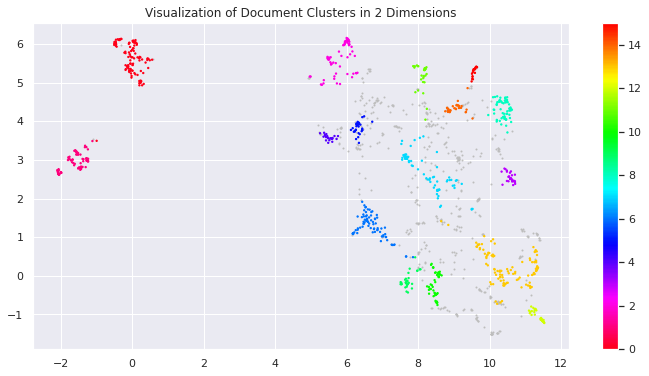

In [150]:
# Visualize the resulting clusters

# Prepare data by creating a 2-dim embedding for each 768-dim vector
umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, 
    min_dist=0.0, metric='cosine').fit_transform(list(df_articles.vectors))

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize the clusters clusters
fig, ax = plt.subplots(figsize=(12, 6))
# Define the outliers and the clusters
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

#Create the plot
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1.0),
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1.8, cmap='hsv_r')
plt.colorbar();
plt.title('Visualization of Document Clusters in 2 Dimensions');

In [50]:
# Add the topic labels to the dataframe
df_articles['labels'] = clusterer.labels_.tolist()

# Check the output
df_articles.head(2)

,article_id,doc_name,vectors,umap_embed,labels
0,0,detect malfunctioning iot sensors with streaming analytics,"[-0.06872767, 0.03079946, -0.006361629, -0.031556632, 0.020434225, -0.008358569, -0.00...","[10.72285270690918, 2.153514862060547, 5.242751598358154, 6.589924335479736, 4.6285653...",-1
1,1,Communicating data science: A guide to presenting your work,"[-0.061654978, 0.050063305, -0.047963202, -0.01333841, 0.01445606, -0.003979498, -0.00...","[10.267996788024902, 1.962630033493042, 6.026888370513916, 6.625016212463379, 4.274230...",7


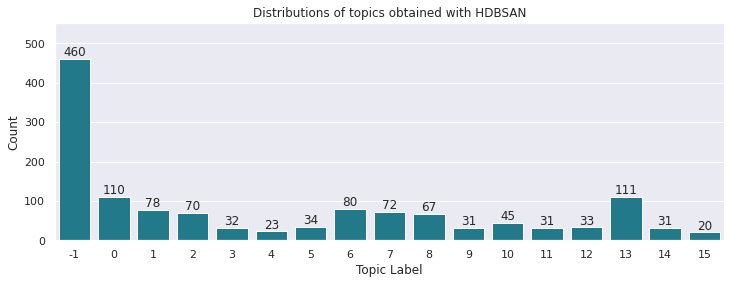

In [51]:
# Visualize the distribution articles by topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(12,4)})
sns.set(font_scale=1)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(x='labels', data=df_articles, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with HDBSAN')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>Noisy samples are given the label -1.
    </ul>
</div>

In [152]:
# Extract topic sizes in a dataframe
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['labels'])
                     .doc_name
                     .count()
                     .reset_index()
                     .rename({'labels': 'topic', 'doc_name': 'size'}, axis='columns')
                     .sort_values('size', ascending=False))
    return topic_sizes

In [157]:
# Display topic sizes in a dataframe
extract_topic_sizes(df_articles)[1:11]

,topic,size
14,13,111
1,0,110
7,6,80
2,1,78
8,7,72
3,2,70
9,8,67
11,10,45
6,5,34
13,12,33


Plot the cluster hierarchy: which clusters are near each other, or could perhaps be merged, and which are far apart. We can access the basic hierarchy via the condensed_tree_ attribute of the clusterer object.

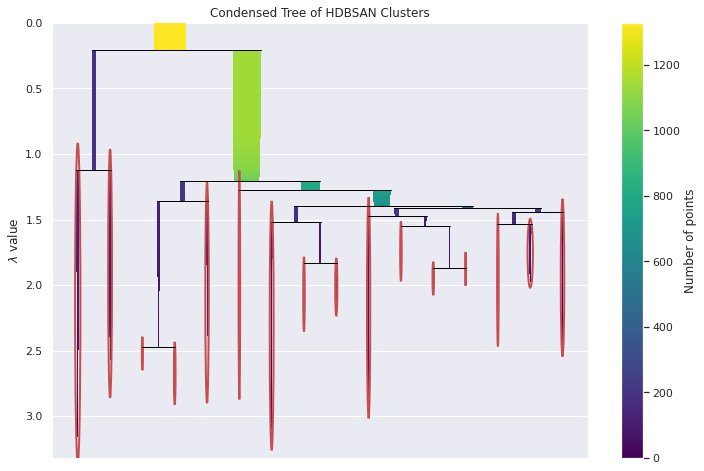

In [84]:
# adjust figure size and font size
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale=1)

clusterer.condensed_tree_.plot(select_clusters=True);

# Add labels and title
plt.title('Condensed Tree of HDBSAN Clusters');

In [107]:
# Evaluate the cluster persistence for the clusters (except -1)
df=pd.DataFrame({'persistence':clusterer.cluster_persistence_}).T
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
persistence,0.44,0.39,0.24,0.39,0.03,0.1,0.31,0.18,0.33,0.12,0.08,0.1,0.22,0.1,0.04,4.84e-03


### <font color='darkblue'>Topic extraction</font>

In [53]:
# Create a single combined document for each cluster of documents
docs_df = df_articles[['doc_name', 'labels']].copy()
docs_per_topic = docs_df.groupby(['labels'], as_index=False).agg({'doc_name': ' '.join})
docs_per_topic

,labels,doc_name
0,-1,detect malfunctioning iot sensors with streaming analytics Data Wrangling at Slack War...
1,0,predicting gentrification using longitudinal census data On the Passage of HB2 in Nort...
2,1,modeling energy usage in new york city using machine learning to predict value of home...
3,2,"this week in data science (april 18, 2017) data science bowl 2017 the greatest public ..."
4,3,Tutorial: How to load Twitter data in IBM dashDB Use dashDB with Tableau Load XML dat...
5,4,learn tensorflow and deep learning together and now! bayesian regularization for #neur...
6,5,using machine learning to predict parking difficulty top 10 machine learning use cases...
7,6,got zip code data? prep it for analytics. – ibm watson data lab – medium Mapping for D...
8,7,Communicating data science: A guide to presenting your work creating the data science ...
9,8,analyze ny restaurant data using spark in dsx 3992 using apache spark to predict at...


<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>We use the class based TF-IDF vectorizer to output a np.array, instead of a sparse matrix,
        the TfidfVectorizer would output.
    </ul>
</div>

In [54]:
# Apply the topic-based TF-IDF vectorizer

def ctfidf(documents, m, ngram_range=(1,1)):
    '''
    Compute tfidf vector for each class document.
    INPUT:
        documents (list) - corpus of documents
        m (int) - number of topics
        ngram_range (tuple) - lower, upper bounds of the range of n-values for word n-grams 
    OUTPUT: 
        tf_idf (np.array) - contains tf_idf scores of each word
        countvec (CountVectorizer) - instance of sklearn count vectorizer
    '''
    
    # Process the documents, create tokens
    countvec = CountVectorizer(
        tokenizer=tokenize,
        ngram_range=ngram_range).fit(documents)
    
    # The size of the corpus
    #len(countvec.get_feature_names())
    
    # Record frequency of each word for each topic in an array
    t = countvec.transform(documents).toarray() # shape = m x #features
    
    # The total number of words (not necessarily unique) in each topic
    w = t.sum(axis=1)
    
    # Divide count frequency by total word count 
    tf = np.divide(t.T, w) # term frequency per topic
    
    # The number of occurencies of each unique word in the corpus
    sum_t = t.sum(axis=0)
    
    # Compute inverse-document-frequency
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    
    # Compute tf-idf score for each word
    tf_idf = np.multiply(tf, idf)

    return tf_idf, countvec

In [56]:
# Apply the class tfidf to the text corpus for unigrams
tf_idf, countvec = ctfidf(docs_per_topic.doc_name.values, docs_per_topic.shape[0])

In [137]:
def extract_top_n_words_per_topic(tf_idf, countvec, docs_per_topic, n):
    '''
    Function to extract the top ngram words from each topic.
    
    INPUT:
        tf_idf (np.array) - contains tf_idf scores of each word
        count (CountVectorizer) - instance of sklearn count vectorizer
        docs_per_topic (pd.DataFrame) - each row contains the topic number and
                                        a compilation of all the documents in the topic
        n (int) - the number of words to return for each topic
    
    OUTPUT:
        top_n_words (dict) - for each topic a list of words and tfidf scores are returned
    '''
    # Extract a list of words
    words = countvec.get_feature_names_out()
    # Create a list of labels
    #labels = list(docs_per_topic.labels)
    labels=list(docs_per_topic.cluster)
    # Extract index locations from the transposed tf-idf matrix  
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    # Create a dictionary with the top n words and their labels
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i,
                   label in enumerate(labels)}
    return top_n_words

In [58]:
# Get the top 10 words in each topic
top_n_words = extract_top_n_words_per_topic(tf_idf, countvec, docs_per_topic, n=10)
top_n_words

{-1: [('microservices', 0.0025599030106386593),
  ('wml', 0.0025599030106386593),
  ('bot', 0.0025599030106386593),
  ('calculating', 0.0025444991253610483),
  ('sentiment', 0.0025444991253610483),
  ('pick', 0.0025444991253610483),
  ('average', 0.0025444991253610483),
  ('stream', 0.0025444991253610483),
  ('stats', 0.0025067092003730348),
  ('bayes', 0.0025067092003730348)],
 0: [('national', 0.01113854411580921),
  ('income', 0.01113854411580921),
  ('oil', 0.01113854411580921),
  ('household', 0.010907089408396754),
  ('caput', 0.010907089408396754),
  ('birth', 0.010907089408396754),
  ('age', 0.010748974008932337),
  ('current', 0.010316712890811588),
  ('road', 0.010316712890811588),
  ('woman', 0.010316712890811588)],
 1: [('antwerp', 0.013946207064446511),
  ('portland', 0.013946207064446511),
  ('san', 0.013946207064446511),
  ('trentino', 0.012539284737745347),
  ('sydney', 0.012539284737745347),
  ('paris', 0.012539284737745347),
  ('athens', 0.012539284737745347),
  ('vie

In [59]:
# Take a look at the top words in the largest cluster
top_n_words[13]

[('transporter', 0.012063172295306885),
 ('rethinkdb', 0.01024378863054383),
 ('openstreetmap', 0.010045952058232275),
 ('view', 0.00945000333298931),
 ('connecting', 0.008564702654448867),
 ('nosql', 0.008564702654448867),
 ('storing', 0.008262803720062821),
 ('elixir', 0.008262803720062821),
 ('geofile', 0.007275789598227608),
 ('backup', 0.007087502499741982)]

In [60]:
df_articles[df_articles['labels']==13].doc_name

3       DataLayer Conference: Boost the performance of your distributed database
5                                          Browsing PostgreSQL Data with Compose
6                                               Upgrading your PostgreSQL to 9.5
17                                                 Compose for MySQL now for you
19                                                Finding the Mode in PostgreSQL
                                          ...                                   
1033                                The Many Flavors of NoSQL at That Conference
1036                                      Finding Duplicate Documents in MongoDB
1040                    How I Stopped Worrying & Learned to Love the Mongo Shell
1055                                               access postgresql with python
1056                                                    access postgresql with r
Name: doc_name, Length: 111, dtype: object

In [61]:
top_n_words[0]

[('national', 0.01113854411580921),
 ('income', 0.01113854411580921),
 ('oil', 0.01113854411580921),
 ('household', 0.010907089408396754),
 ('caput', 0.010907089408396754),
 ('birth', 0.010907089408396754),
 ('age', 0.010748974008932337),
 ('current', 0.010316712890811588),
 ('road', 0.010316712890811588),
 ('woman', 0.010316712890811588)]

In [62]:
df_articles[df_articles['labels']==0].doc_name

64                               predicting gentrification using longitudinal census data
450                                               On the Passage of HB2 in North Carolina
1057             adolescent fertility rate (births per 1,000 women ages 15-19), worldwide
1058                                       agriculture, value added (% of gdp) by country
1137                                                        annual % inflation by country
                                              ...                                        
1323                                                                  world marriage data
1324                                 world tourism data by the world tourism organization
1325    worldwide county and region - national accounts - gross national income 1948-2010
1326                                worldwide electricity demand and production 1990-2012
1327                    worldwide fuel oil consumption by household (in 1000 metric tons)
Name: doc_

In [64]:
# The top words in the smallest cluster
top_n_words[15]

[('github', 0.06430751035272557),
 ('sign', 0.03148014826729129),
 ('accelerate', 0.03148014826729129),
 ('trial', 0.03148014826729129),
 ('interactively', 0.03148014826729129),
 ('social', 0.02719500959160257),
 ('workflow', 0.023778512927736344),
 ('loading', 0.023778512927736344),
 ('publish', 0.023778512927736344),
 ('emr', 0.023778512927736344)]

In [65]:
df_articles[df_articles['labels']==15].doc_name

20        working interactively with rstudio and notebooks in dsx
31                                Sign up for a free trial in DSX
75                                      Tour the Community in DSX
182                                Overview of RStudio IDE in DSX
277                             work with data connections in dsx
302                             accelerate your workflow with dsx
323                                  manage object storage in dsx
355                      run shiny applications in rstudio in dsx
373                                 working with notebooks in dsx
395                               run dsx notebooks on amazon emr
409                       using github for project control in dsx
474                            publish notebooks to github in dsx
665                         get social with your notebooks in dsx
682         easy json loading and social sharing in dsx notebooks
708                      load and analyze public data sets in dsx
763       

In [ ]:
# Compute the Coherence Index per Cluster

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

### <font color='darkblue'>Clustering with KMeans</font>

In [108]:
def clustering_question(metadata,NUM_CLUSTERS):

    sentences = metadata['doc_name']

    X = np.array(metadata['vectors'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    metadata['cluster'] = pd.Series(assigned_clusters, index=metadata.index)
    metadata['centroid'] = metadata['cluster'].apply(lambda x: kclusterer.means()[x])

    return metadata, assigned_clusters


In [110]:
# Create a list of vectors for Kmeans model 
X = np.array(df_articles['vectors'].tolist())

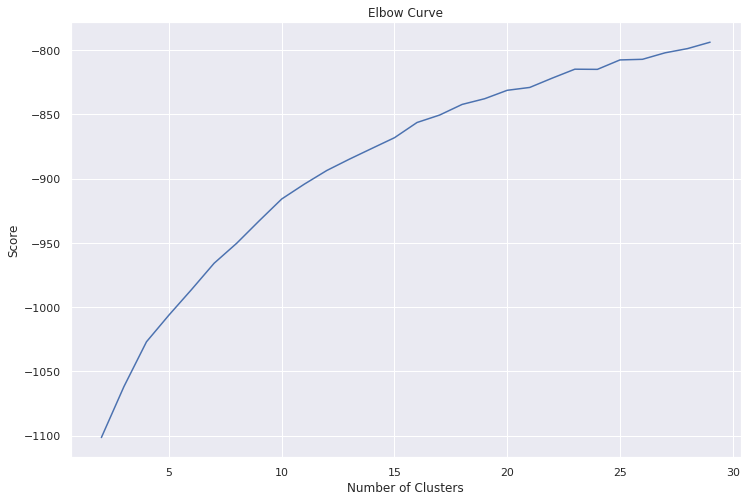

In [115]:
TOKENIZERS_PARALLELISM=False
# Plot the elbow curve to find the optimal number of clusters 
# Choose the number of clusters
nc = range(2, 30)
# Evaluate K-Means for each selection of clusters
kmeans = [KMeans(n_clusters=i) for i in nc]
# Compute the score (negative of the K-Means objective)
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
# Create the plot, labels and title
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

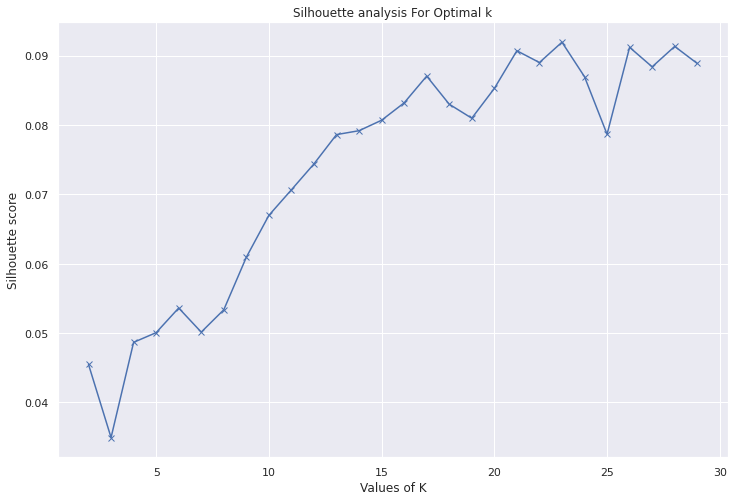

In [116]:
# PLot also the silhouette scores for several cluster numbers
from sklearn.metrics import silhouette_score

silhouette_avg = []
range_n_clusters = list(range(2,30))
                    
for k in range_n_clusters:
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X, labels, metric = 'euclidean'))


plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.

In [134]:
# Perform kmean clustering
num_clusters = 24
clustering_model = KMeans(n_clusters=num_clusters, random_state=0)
kmeans=clustering_model.fit(X)
df_articles['cluster'] = kmeans.labels_

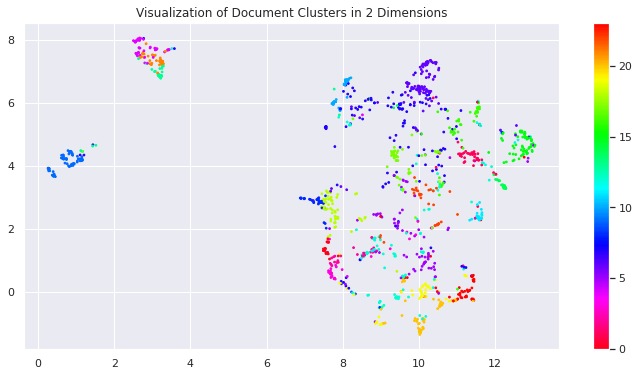

In [135]:
# Prepare data by creating a 2-dim embedding for each 768-dim vector
umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, 
    min_dist=0.0, metric='cosine').fit_transform(list(df_articles.vectors))

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = kmeans.labels_

# Visualize the clusters clusters
fig, ax = plt.subplots(figsize=(12, 6))
clustered = result.loc[result.labels != -1, :]

#Create the plot
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=3, cmap='hsv_r')
plt.colorbar();
plt.title('Visualization of Document Clusters in 2 Dimensions');

### <font color='darkblue'>Extract Topics from Clusters</font>

In [136]:
# Create a single combined document for each cluster of documents
docs_kmeans = df_articles[['doc_name', 'cluster']].copy()
docs_per_topic_kmeans = docs_kmeans.groupby(['cluster'], as_index=False).agg({'doc_name': ' '.join})
docs_per_topic_kmeans

,cluster,doc_name
0,0,Move CSVs into different JSON doc stores cloudant/meteor-couchdb Simple CouchDB and Cl...
1,1,top 20 r machine learning and data science packages how to map usa rivers using ggplot...
2,2,Offline-First iOS Apps with Swift & Cloudant Sync; Part 1: The Datastore Introducing C...
3,3,Tutorial: How to build and query a Cloudant geospatial index For Developers: Querying ...
4,4,co2 emissions (metric tons per capita) by country consumption of ozone-depleting cfcs ...
...,...,...
19,19,Warehousing GeoJSON documents Customizing MongoDB’s Shell with Compact Prompts Find Mo...
20,20,Browsing PostgreSQL Data with Compose Compose for MySQL now for you Getting Started wi...
21,21,"adolescent fertility rate (births per 1,000 women ages 15-19), worldwide agriculture, ..."
22,22,Install IBM Database Conversion Workbench use data assets in a project using ibm data ...


In [139]:
# Apply the class tfidf to the corpus 
tfidf_kmeans, countvec_kmeans = ctfidf(docs_per_topic_kmeans.doc_name.values, 24)

In [140]:
# Get the top 10 words in each topic
top_n_words_kmeans = extract_top_n_words_per_topic(tfidf_kmeans, countvec_kmeans, docs_per_topic_kmeans, n=10)
top_n_words_kmeans

{0: [('couchdb', 0.040860824848109586),
  ('move', 0.03820600562147697),
  ('disk', 0.0322394037469742),
  ('ld', 0.02463607620424764),
  ('copy', 0.02463607620424764),
  ('dynamodb', 0.02463607620424764),
  ('linked', 0.02463607620424764),
  ('lucene', 0.02463607620424764),
  ('csvs', 0.02463607620424764),
  ('couchdiff', 0.02463607620424764)],
 1: [('tidyr', 0.03185350167516542),
  ('ggplot', 0.03185350167516542),
  ('shiny', 0.029296327697816264),
  ('cheat', 0.02738097069539183),
  ('sheet', 0.02738097069539183),
  ('dplyr', 0.02208805910922667),
  ('interactive', 0.02190477655631346),
  ('package', 0.018483924814931874),
  ('write', 0.01592675083758271),
  ('best', 0.01592675083758271)],
 2: [('sync', 0.02990640003137457),
  ('swift', 0.02609358450332119),
  ('dive', 0.024125307279495148),
  ('pouchdb', 0.02272306478299733),
  ('io', 0.021332277449866207),
  ('mobile', 0.01699939295832815),
  ('kiwi', 0.015427445778388085),
  ('ical', 0.015427445778388085),
  ('request', 0.0154274

In [141]:
df_articles.head()

,article_id,doc_name,vectors,umap_embed,labels,cluster
0,0,detect malfunctioning iot sensors with streaming analytics,"[-0.06872767, 0.03079946, -0.006361629, -0.031556632, 0.020434225, -0.008358569, -0.00...","[10.72285270690918, 2.153514862060547, 5.242751598358154, 6.589924335479736, 4.6285653...",-1,12
1,1,Communicating data science: A guide to presenting your work,"[-0.061654978, 0.050063305, -0.047963202, -0.01333841, 0.01445606, -0.003979498, -0.00...","[10.267996788024902, 1.962630033493042, 6.026888370513916, 6.625016212463379, 4.274230...",7,17
2,2,"this week in data science (april 18, 2017)","[-0.043030184, 0.06632714, -0.050089184, 0.0007826319, -0.041923475, -0.031681906, 0.0...","[8.908665657043457, 2.902090072631836, 6.502479553222656, 6.166719913482666, 4.1112108...",2,10
3,3,DataLayer Conference: Boost the performance of your distributed database,"[-0.011356175, 0.034742426, -0.01652083, 0.054450057, -0.032811232, -0.016584424, 0.01...","[10.997697830200195, 2.010314702987671, 4.313645362854004, 6.203137397766113, 4.697679...",13,5
4,4,analyze ny restaurant data using spark in dsx,"[-0.044875752, 0.059194077, -0.036207564, 0.015440248, 0.035330776, 0.028467895, 0.021...","[11.227458953857422, 2.5481929779052734, 5.317620277404785, 6.990108966827393, 4.00053...",8,15


In [145]:
# Drop the articles that are not in one of the clusters 
df_topics = df_articles[df_articles.labels!=-1]
df_topics.shape

(868, 6)

In [144]:
df_articles.shape

(1328, 6)

In [146]:
df_articles[df_articles.labels==1]

,article_id,doc_name,vectors,umap_embed,labels,cluster
213,213,modeling energy usage in new york city,"[-0.049413335, 0.081872776, -0.0058558593, 0.0048752003, 0.036647525, 0.016484352, 0.0...","[4.293089389801025, 4.186918258666992, 5.6917901039123535, 5.937004566192627, 4.198259...",1,13
415,415,using machine learning to predict value of homes on airbnb,"[-0.031922605, 0.09207876, -0.0426934, -0.00035379027, -0.010593259, -0.007586693, 0.0...","[4.187721252441406, 4.086604118347168, 5.7307658195495605, 5.8206281661987305, 4.21556...",1,9
428,428,data science experience demo: modeling energy usage in nyc,"[-0.06345229, 0.08409628, -0.020279566, -0.0081222085, 0.02444203, 0.011183232, 0.0271...","[4.212803363800049, 4.182007312774658, 5.67319917678833, 5.899889945983887, 4.19462299...",1,17
585,585,tidyverse practice: mapping large european cities,"[-0.059473317, -0.008666621, -0.00813692, -0.026475746, 0.0015819679, 0.0223151, 0.018...","[4.526835918426514, 4.182408332824707, 5.693232536315918, 6.060702800750732, 4.2024965...",1,7
865,865,analyze traffic data from the city of san francisco,"[-0.02737772, 0.09494866, -0.0546602, 0.024958305, -0.0072213933, 0.0009381561, 0.0195...","[4.3508992195129395, 4.135375499725342, 5.721319198608398, 5.929312705993652, 4.208351...",1,7
...,...,...,...,...,...,...
1127,1157,airbnb data for analytics: washington d.c. listings,"[-0.05758582, 0.08365344, -0.047343336, -0.024321223, 0.015785484, -0.0016284578, 0.02...","[4.040456295013428, 4.0702996253967285, 5.712075233459473, 5.768571853637695, 4.234579...",1,9
1128,1158,airbnb data for analytics: washington d.c. reviews,"[-0.056344215, 0.09994379, -0.0441788, -0.023718491, -0.0061585577, -0.012317293, 0.03...","[4.273319244384766, 4.0944952964782715, 5.7634077072143555, 5.8688812255859375, 4.2230...",1,9
1132,1162,analyze energy consumption in buildings,"[-0.056432135, 0.03698009, -0.002517761, 0.058228023, 0.010590645, -0.0055149808, 0.00...","[4.2168121337890625, 4.206144332885742, 5.66496467590332, 5.9208197593688965, 4.189615...",1,13
1213,1292,find airbnb deals in portland with machine learning using r,"[-0.047327965, 0.07246567, -0.04037847, -0.0042993906, 0.022267085, 0.006203101, 0.026...","[4.130152225494385, 4.065590858459473, 5.719783782958984, 5.786423206329346, 4.2231960...",1,9


Create cold start: get the most popular article from the 10 most popular topics.